#Загрузка данных

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torchvision
from torch.optim.lr_scheduler import StepLR
from torchvision import models as vision_models

In [ ]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ioai-journey-to-springfield.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: journe

#Подготовка датасета

In [ ]:
'''
dataset = datasets.ImageFolder(root='/content/journey-springfield/train/simpsons_dataset', transform=transforms.Compose([transforms.ToTensor(),  transforms.Resize((224, 224))]))
dataloader = DataLoader(dataset, batch_size=32)

mean = torch.zeros(3)
std = torch.zeros(3)
for images, _ in dataloader:
    mean += images.mean((0, 2, 3))
    std += images.std((0, 2, 3))

mean /= len(dataloader)
std /= len(dataloader)

print("Mean:", mean)
print("Std:", std)
'''

Mean: tensor([0.4623, 0.4075, 0.3524])
Std: tensor([0.2453, 0.2229, 0.2549])


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.08, saturation=0.1, hue=0.05),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4623, 0.4075, 0.3524], std=[0.2453, 0.2229, 0.2549])
])

test_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4623, 0.4075, 0.3524], std=[0.2453, 0.2229, 0.2549])
])
'''
transforms.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение с вероятностью 50%
    transforms.RandomVerticalFlip(p=0.5),  # Случайное вертикальное отражение с вероятностью 50%
    transforms.RandomRotation(degrees=45),  # Случайный поворот на угол до 45 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение яркости, контраста, насыщенности и оттенка
    transforms.RandomGrayscale(p=0.1),  # Случайное преобразование в градации серого с вероятностью 10%
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
'''

In [ ]:
# Загрузка данных
train_dataset = datasets.ImageFolder(root='/content/journey-springfield/train/simpsons_dataset', transform=train_transform) #Вот тут я ошибку допустила, потому что и трейн, и вал преобразовала вместе (то есть, в вал тоже пошли картинки с аугментацией, а, значит, там не прям точные результаты будут). Не следовало, но поняла я это за примерно час до конца соревы, так что оставила так ахах. Ну, что сделано - то сделано, ладно.
test_data = datasets.ImageFolder(root='/content/journey-springfield/testset/', transform=test_transform)

In [ ]:
file_names = [item[0] for item in train_dataset.samples]
file_names = [os.path.basename(path) for path in file_names]

In [ ]:
len(train_dataset.classes) #Количество классов:

42

In [ ]:
# we will allocate 80% of all images to the training sample
train_size = int(len(train_dataset) * 0.8)
# the remaining 20% will go to validation
val_size = len(train_dataset) - train_size

# splitting the data
torch.manual_seed(42)
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

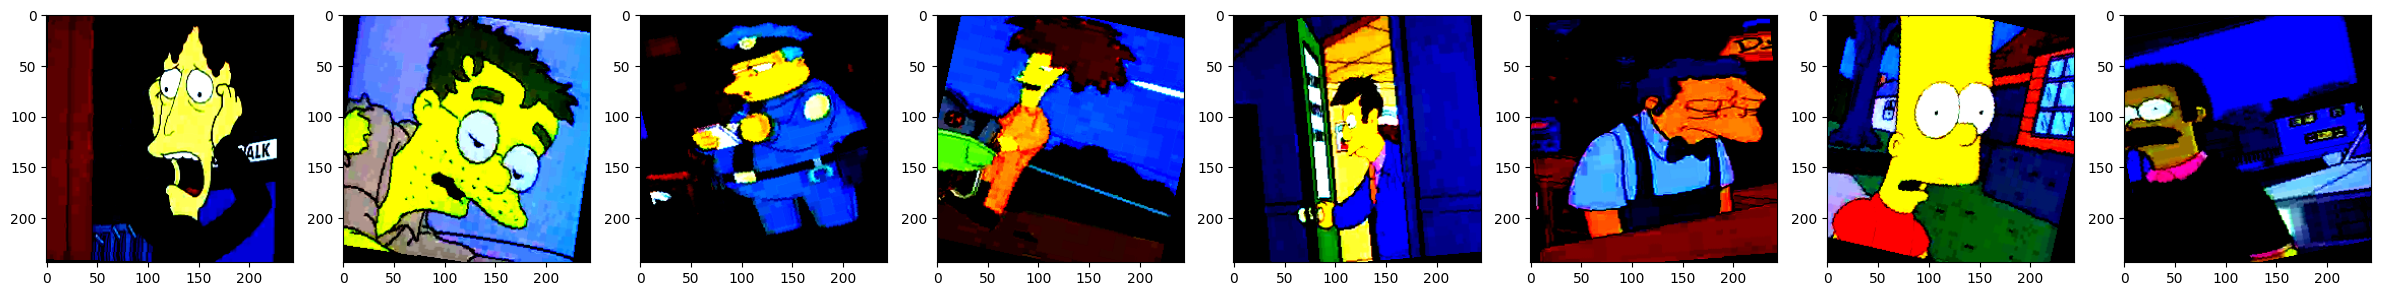

In [ ]:
f, axes= plt.subplots(1, 8, figsize=(30,5))

for i, axis in enumerate(axes):
    img, label = train_data[i]
    img = np.transpose(img, (1, 2, 0)) #Крч, торч требует, чтобы размерность тензора типа ([количество цветовых каналов, ширина изображения, высота изображения]), а imshow() ожидает вектора типа ([ширина изображения, высота изображения, количество цветовых каналов])
    axes[i].imshow(img)
plt.show()

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

#Модели и обучение

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)
        for name, param in self.model.named_parameters():
            if "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.num_classes = num_classes

    def forward(self, batch):
        inputs, _ = batch
        return self.model(inputs)

In [ ]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.model = vision_models.efficientnet_b1(vision_models.EfficientNet_B1_Weights.DEFAULT)
        self.model.classifier[1] = torch.nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, batch):
        inputs, _ = batch
        return self.model(inputs)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet(num_classes=42).to(device)
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


EfficientNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_ac

In [ ]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.6, inplace=True),
    nn.Linear(in_features=512, out_features=128, bias=True),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(128),
    nn.Dropout(p=0.6, inplace=True),
    nn.Linear(in_features=128, out_features=42, bias=True),
    nn.LeakyReLU(42),
    nn.BatchNorm1d(42),
    nn.Linear(in_features=42, out_features=42, bias=True),
)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

best_val_f1 = 0.0
best_model_path = 'best_model.pth'

num_epochs = 12

scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_true = []
    train_pred = []

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model((inputs, None))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


        preds = torch.argmax(outputs, dim=1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())

    train_f1 = f1_score(train_true, train_pred, average='weighted')
    train_losses.append(running_loss / len(train_loader))
    train_f1_scores.append(train_f1)

    scheduler.step()
    model.eval()
    val_running_loss = 0.0
    val_true = []
    val_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model((inputs, None))
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())

    val_f1 = f1_score(val_true, val_pred, average='weighted')
    val_losses.append(val_running_loss / len(val_loader))
    val_f1_scores.append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f'New best model saved with F1: {best_val_f1:.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val F1: {val_f1:.4f}')

100%|██████████| 262/262 [00:58<00:00,  4.49it/s]


New best model saved with F1: 0.9501
Epoch [1/12], Train Loss: 0.5688, Train F1: 0.8526, Val Loss: 0.2020, Val F1: 0.9501


100%|██████████| 262/262 [00:57<00:00,  4.54it/s]


New best model saved with F1: 0.9530
Epoch [2/12], Train Loss: 0.2104, Train F1: 0.9436, Val Loss: 0.1810, Val F1: 0.9530


100%|██████████| 262/262 [00:57<00:00,  4.56it/s]


New best model saved with F1: 0.9688
Epoch [3/12], Train Loss: 0.1511, Train F1: 0.9599, Val Loss: 0.1385, Val F1: 0.9688


100%|██████████| 262/262 [00:57<00:00,  4.54it/s]


Epoch [4/12], Train Loss: 0.1206, Train F1: 0.9677, Val Loss: 0.1765, Val F1: 0.9593


100%|██████████| 262/262 [00:57<00:00,  4.55it/s]


New best model saved with F1: 0.9818
Epoch [5/12], Train Loss: 0.0483, Train F1: 0.9878, Val Loss: 0.0841, Val F1: 0.9818


100%|██████████| 262/262 [00:56<00:00,  4.63it/s]


New best model saved with F1: 0.9823
Epoch [6/12], Train Loss: 0.0270, Train F1: 0.9929, Val Loss: 0.0893, Val F1: 0.9823


100%|██████████| 262/262 [00:56<00:00,  4.62it/s]


New best model saved with F1: 0.9844
Epoch [7/12], Train Loss: 0.0200, Train F1: 0.9947, Val Loss: 0.0850, Val F1: 0.9844


100%|██████████| 262/262 [00:56<00:00,  4.61it/s]


Epoch [8/12], Train Loss: 0.0156, Train F1: 0.9958, Val Loss: 0.0866, Val F1: 0.9824


100%|██████████| 262/262 [00:57<00:00,  4.54it/s]


New best model saved with F1: 0.9858
Epoch [9/12], Train Loss: 0.0092, Train F1: 0.9977, Val Loss: 0.0780, Val F1: 0.9858


100%|██████████| 262/262 [00:58<00:00,  4.48it/s]


New best model saved with F1: 0.9861
Epoch [10/12], Train Loss: 0.0079, Train F1: 0.9978, Val Loss: 0.0779, Val F1: 0.9861


  6%|▌         | 59/1047 [00:18<05:05,  3.23it/s]


KeyboardInterrupt: 

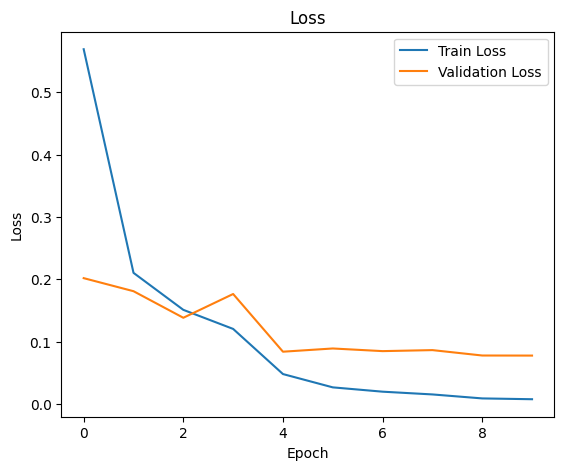

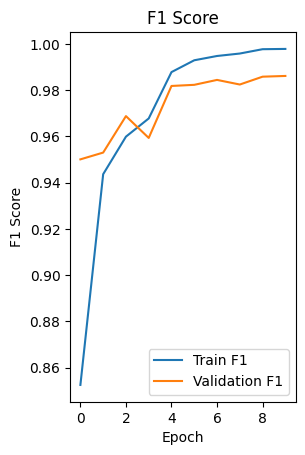

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1')
plt.plot(val_f1_scores, label='Validation F1')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
best_model_path = 'best_model.pth'
#model = ResNet34(num_classes=42).to(device)
model.load_state_dict(torch.load(best_model_path))

<ipython-input-44-18d4772b553f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [ ]:
# Список для хранения предсказаний
predictions = []

with torch.no_grad():
    for images, image_names in tqdm(test_loader):
        images = images.to(device)
        outputs = model((images, None))
        _, predicted = torch.max(outputs, 1)

        # Сохраняем предсказания
        predictions.extend(predicted.cpu().numpy())

100%|██████████| 62/62 [00:05<00:00, 11.96it/s]


In [ ]:
file_names = [os.path.basename(item[0]) for item in test_data.samples]
class_names = train_dataset.classes
predicted_classes = [class_names[p] for p in predictions]

In [ ]:
results = pd.DataFrame({
    'Id': file_names,
    'Expected': predicted_classes
})

results.to_csv('submission.csv', index=False)


In [ ]:
results

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


#YOLO classification


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
train_dir = "/content/journey-springfield/train/simpsons_dataset"
yolo_data_dir = "yolo_data2"
test_dir = "/content/journey-springfield/testset/testset"

os.makedirs(os.path.join(yolo_data_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(yolo_data_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(yolo_data_dir, "test"), exist_ok=True)

shutil.copytree(test_dir, os.path.join(yolo_data_dir, "test", 'testset'))

class_names = sorted(os.listdir(train_dir))

with open(os.path.join(yolo_data_dir, "class_names.txt"), "w") as f:
    for idx, class_name in enumerate(class_names):
        f.write(f"{idx}: {class_name}\n")


for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)

    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(yolo_data_dir, "train", class_name), exist_ok=True)
    os.makedirs(os.path.join(yolo_data_dir, "val", class_name), exist_ok=True)

    for img in train_images:
        shutil.copy(
            os.path.join(class_dir, img),
            os.path.join(yolo_data_dir, "train", class_name, img)
        )

    for img in val_images:
        shutil.copy(
            os.path.join(class_dir, img),
            os.path.join(yolo_data_dir, "val", class_name, img)
        )

In [ ]:
for split in ["train", "val"]:
    split_dir = os.path.join(yolo_data_dir, split)
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        for img in os.listdir(class_dir):
            label_file = os.path.join(class_dir, os.path.splitext(img)[0] + ".txt")
            class_id = list(os.listdir(train_dir)).index(class_name)
            with open(label_file, "w") as f:
                f.write(str(class_id))

In [ ]:
data_yaml = f"""
path: /content/yolo_data2
train: train
val: val

nc: 42
names: {sorted(os.listdir(train_dir))}
"""
with open(os.path.join('/content/yolo_data2', 'data.yaml'), 'w') as f:
    f.write(data_yaml)

In [ ]:
model = YOLO("yolo11n-cls.pt")

100%|██████████| 5.52M/5.52M [00:00<00:00, 82.9MB/s]


In [ ]:
results = model.train(
    data='/content/yolo_data2',
    lr0 = 0.001,  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
    lrf = 0.005,  # final learning rate (lr0 * lrf)
    momentum = 0.937,  # SGD momentum/Adam beta1
    #weight_decay = 0.0005,  # optimizer weight decay 5e-4
    #warmup_epochs = 3.0,  # warmup epochs (fractions ok)
    hsv_h = 0.01,  # image HSV-Hue augmentation (fraction)
    hsv_s = 0.4,  # image HSV-Saturation augmentation (fraction)
    hsv_v = 0.2,  # image HSV-Value augmentation (fraction)
    degrees = 10.0,  # image rotation (+/- deg)
    scale = 0.2,  # image scale (+/- gain)
    shear =  0.2,  # image shear (+/- deg) from -0.5 to 0.5
    perspective = 0.1,  # image perspective (+/- fraction), range 0-0.001
    fliplr = 0.5,  # image flip left-right (probability)
    mosaic = 0.3,  # image mosaic (probability)
    mixup = 0.1,  # image mixup (probability)
    epochs=5,  # Количество эпох
    imgsz=640,  # Размер изображения
    batch=16,  # Размер батча
    device='0', # Использовать GPU (если доступно)
    single_cls=False # для обучения с учетом классов на основании data.yaml
)

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=/content/runs/classify/train/weights/best.pt, data=/content/yolo_data2, epochs=5, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

train: Scanning /content/yolo_data2/train... 16727 images, 0 corrupt: 100%|██████████| 16727/16727 [00:00<?, ?it/s]
val: Scanning /content/yolo_data2/val... 4206 images, 0 corrupt: 100%|██████████| 4206/4206 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000217, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 263/263 [01:23<00:00,  3.17it/s]

                   all      0.834      0.942



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 263/263 [01:25<00:00,  3.06it/s]

                   all      0.898      0.969



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 263/263 [01:28<00:00,  2.98it/s]

                   all      0.923      0.979



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 263/263 [01:26<00:00,  3.05it/s]

                   all      0.934      0.983



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 263/263 [01:27<00:00,  3.02it/s]

                   all      0.941      0.986



5 epochs completed in 1.008 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.3MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 3.3MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,579,826 parameters, 0 gradients, 3.2 GFLOPs
train: /content/yolo_data2/train... found 16727 images in 42 classes ✅ 
val: /content/yolo_data2/val... found 4206 images in 42 classes ✅ 
test: /content/yolo_data2/test... found 991 images in 1 classes: ERROR ❌️ requires 42 classes, not 1


               classes   top1_acc   top5_acc: 100%|██████████| 263/263 [01:28<00:00,  2.98it/s]


                   all      0.941      0.986
Speed: 0.7ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


In [ ]:
model = YOLO('/content/runs/classify/train/weights/best.pt')

In [ ]:
test_images = os.listdir(os.path.join('/content/yolo_data2/test/testset'))
predictions = []

for image_name in test_images:
    image_path = os.path.join('/content/yolo_data2/test/testset', image_name)
    results = model.predict(image_path)
    predicted_class = results[0].probs.top1  # Индекс предсказанного класса
    predicted_label = class_names[predicted_class]
    predictions.append((image_name, predicted_label))


image 1/1 /content/yolo_data2/test/testset/img774.jpg: 640x640 lisa_simpson 0.99, maggie_simpson 0.01, charles_montgomery_burns 0.00, sideshow_bob 0.00, milhouse_van_houten 0.00, 4.6ms
Speed: 11.9ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_data2/test/testset/img908.jpg: 640x640 moe_szyslak 1.00, patty_bouvier 0.00, marge_simpson 0.00, chief_wiggum 0.00, selma_bouvier 0.00, 4.9ms
Speed: 11.2ms preprocess, 4.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_data2/test/testset/img707.jpg: 640x640 milhouse_van_houten 1.00, groundskeeper_willie 0.00, patty_bouvier 0.00, maggie_simpson 0.00, krusty_the_clown 0.00, 4.6ms
Speed: 11.2ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_data2/test/testset/img860.jpg: 640x640 mayor_quimby 0.98, cletus_spuckler 0.01, nelson_muntz 0.00, snake_jailbird 0.00, principal_skinner 0.00, 

In [ ]:
df = pd.DataFrame(predictions, columns=["Id", "Expected"])
df.to_csv("predictions.csv", index=False)